# Import packages and read data

In [1]:
# !pip install textnets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textnets as tn
import networkx as nx
tn.params["autodownload"] = True

/Users/jayanthspratap/opt/anaconda3/envs/mgh-ortho/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading data: Uncomment one line to read the desired data file and proceed with the text network analysis.

In [232]:
# GPT-3.5

# by source
# data = pd.read_csv('NA_TE.csv', index_col='Website')
# data = pd.read_csv('NA_CTS.csv', index_col='Website')
# data = pd.read_csv('NA_PRP_thumb.csv', index_col='Website')

# by type
# data = pd.read_csv('NA_TE copy.csv', index_col='Type')
# data = pd.read_csv('NA_CTS.csv', index_col='Type')
# data = pd.read_csv('NA_PRP_thumb.csv', index_col='Type')[['Name', 'Website', 'text']]
# data = data.groupby(by = data.index).sum()

# GPT-4

# by source
# data = pd.read_csv('NA4_TE.csv', index_col='Website')
# data = pd.read_csv('NA4_CTS.csv', index_col='Website')
# data = pd.read_csv('NA4_PRP_thumb.csv', index_col='Website')

# by type
# data = pd.read_csv('NA4_TE.csv', index_col='Type')[['Name', 'Website', 'text']]
# data = pd.read_csv('NA4_CTS.csv', index_col='Type')[['Name', 'Website', 'text']]
# data = pd.read_csv('NA4_PRP_thumb.csv', index_col='Type')[['Name', 'Website', 'text']]
# data = data.groupby(by = data.index).sum()

In [246]:
data

,Name,text
Website,,
W1,Mayo Clinic,Tennis elbow (lateral epicondylitis) is a pain...
W2,Johns Hopkins,"Lateral epicondylitis, commonly known as tenni..."
W3,Cleveland Clinic,Tennis elbow is an overuse injury that occurs ...
W4,WebMD,Tennis elbow is a type of tendinitis -- swelli...
W5,AAOS,"Tennis elbow, or lateral epicondylitis, is a p..."
...,...,...
C16,ChatGPT 16,"Tennis elbow, also known as lateral epicondyli..."
C17,ChatGPT 17,"Tennis elbow, also known as lateral epicondyli..."
C18,ChatGPT 18,"Tennis elbow, also known as lateral epicondyli..."


# Construct corpus and text network

In [247]:
# construct corpus from dataset
corpus = tn.Corpus(data['text'])

# tokenize and generate text network
t = tn.Textnet(corpus.tokenized(), remove_weak_edges=True)

# by trigrams
# t = tn.Textnet(corpus.ngrams(3), remove_weak_edges=True)

In [248]:
# plot entire network

# t.plot(label_nodes=True,
#        show_clusters=True,
#        scale_nodes_by="birank",
#        scale_edges_by="weight",
#        bbox=(1200, 1200))

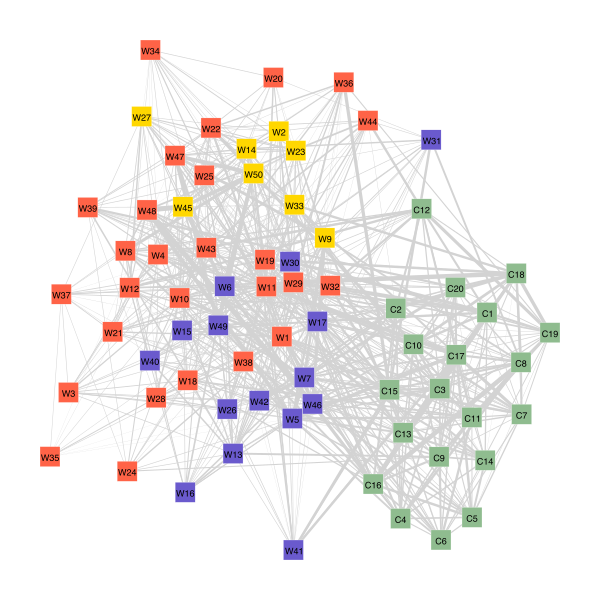

In [249]:
# project network onto terms
words = t.project(node_type="term")

# project network onto docs
sources = t.project(node_type="doc")

# plot docs network, with node and edge scaling
sources.plot(label_nodes=True,
        # scale_nodes_by="betweenness",
        color_clusters=True,
        edge_width=words.edges["weight"],
        alpha=0.25
        )

# Nodes as individual sources

**Only uncomment and run if data is read "as source"!**

### Construct text network for all individual ChatGPT samples

In [250]:
# construct 20xN matrix
weights = []

for i in range(1, 21):

    # select sample
    samples = [label.startswith('W') or label == f'C{i}' for label in data.index]
    sampled = data.loc[samples]

    # construct corpus from dataset
    sampled_corpus = tn.Corpus(sampled['text'])

    # tokenize and generate text network
    sampled_t = tn.Textnet(sampled_corpus.tokenized(), remove_weak_edges=True)

    # project network onto terms
    sampled_words = sampled_t.project(node_type="term")

    # project network onto docs
    sampled_sources = sampled_t.project(node_type="doc")

    # record graph edges and vertices
    sampled_e = sampled_sources.graph.get_edge_dataframe()
    sampled_v = sampled_sources.graph.get_vertex_dataframe()

    # get vector of weights
    node_weights = []

    v_id = sampled_v[sampled_v.id == f'C{i}'].index[0]

    for node in sampled_v.index.values[1:]:
        edge_id = sampled_sources.graph.get_eid(v_id, node, directed=False, error=False)
        if edge_id != -1:
            node_weights.append(sampled_e.loc[edge_id].weight)
        else:
            node_weights.append(0)

    weights.append(node_weights)

### Rank sources of ChatGPT information

In [251]:
# average weights
mean_weights = np.mean(weights, axis=0)
sem_weights = np.std(weights, axis=0, ddof=1) / np.sqrt(np.size(weights, axis=0))

# match with sources
sources_weights = dict(zip(sampled_v.id.values[1:], mean_weights))
sources_error = dict(zip(sampled_v.id.values[1:], sem_weights))

# sort by weight
sorted_weights = dict(sorted(sources_weights.items(), key = lambda x: x[1], reverse=True))

In [252]:
# match with website name and store in dataframe
df = pd.DataFrame.from_dict(sources_weights, orient='index', columns=['Weight'])
df = pd.merge(df, data['Name'], left_index=True, right_index=True)
df['Error'] = sem_weights
df

In [253]:
n = 10
top_n_sites = list(sorted_weights.keys())[:n]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
df.loc[top_n_sites].plot.bar(x = 'Name', y = 'Weight', \
                              yerr = 'Error',\
                              legend = None, \
                              color = plt.get_cmap('Spectral_r')(rescale(df.loc[top_n_sites].Weight.values)))
plt.xticks(rotation = 80)
plt.xlabel('Website')
plt.ylabel('TF-IDF similarity')
# plt.title("Platelet-Rich Plasma")
plt.title("Carpal Tunnel Syndrome")
plt.show()
# plt.gca().invert_yaxis()

### Calculate betweenness centrality

In [288]:
# construct 20xN matrix
betweenness = []

for i in range(1, 21):

    # select sample
    samples = [label.startswith('W') or label == f'C{i}' for label in data.index]
    sampled = data.loc[samples]

    # construct corpus from dataset
    sampled_corpus = tn.Corpus(sampled['text'])

    # tokenize and generate text network
    sampled_t = tn.Textnet(sampled_corpus.tokenized(), remove_weak_edges=True)

    # project network onto terms
    sampled_words = sampled_t.project(node_type="term")

    # project network onto docs
    sampled_sources = sampled_t.project(node_type="doc")

    # get betweenness of projected network
    sampled_betweenness = sampled_sources.betweenness.values
    # sampled_betweenness = list(nx.second_order_centrality(sampled_sources.graph.to_networkx()).values())
    
    betweenness.append(sampled_betweenness)

# betweenness IDs
ids = list(sampled_sources.betweenness.keys())

In [289]:
# average betweenness
mean_betweenness = np.mean(betweenness, axis=0)
sem_betweenness = np.std(betweenness, axis=0, ddof=1) / np.sqrt(np.size(betweenness, axis=0))

# match with sources
sources_betweenness = dict(zip(ids, mean_betweenness))
sources_error = dict(zip(ids, sem_betweenness))

# sort by betweenness
sorted_betweenness = dict(sorted(sources_betweenness.items(), key = lambda x: x[1], reverse=True))

In [290]:
# match with website name and store in dataframe
df = pd.DataFrame.from_dict(sources_betweenness, orient='index', columns=['Weight'])
df = pd.merge(df, data['Name'], left_index=True, right_index=True)
df.at['C20', 'Name'] = 'ChatGPT'
df['Error'] = sem_betweenness
df

,Weight,Name,Error
C20,0.00,ChatGPT,0.000000
W1,25.85,Mayo Clinic,0.371873
W10,1.75,Ortho Atlanta,0.123010
W11,133.90,MSSPC,0.908730
W12,0.00,Medline Plus,0.000000
W13,0.00,NIH,0.000000
W14,0.65,Cedars Sinai,0.073449
W15,0.00,Healthline,0.000000
W16,0.00,The Center,0.000000
W17,35.60,Orthopedic Institute of Pennsylvania,0.358359


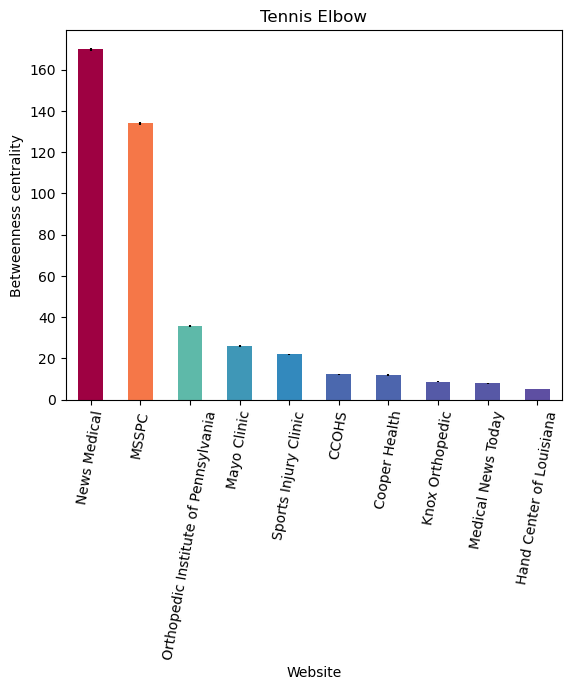

In [291]:
n = 10
top_n_sites = list(sorted_betweenness.keys())[:n]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
df.loc[top_n_sites].plot.bar(x = 'Name', y = 'Weight', \
                              yerr = 'Error',\
                              legend = None, \
                              color = plt.get_cmap('Spectral_r')(rescale(df.loc[top_n_sites].Weight.values)))
plt.xticks(rotation = 80)
plt.xlabel('Website')
plt.ylabel('Betweenness centrality')
plt.title("Tennis Elbow")
# plt.title("Carpal Tunnel Syndrome")
# plt.title("Platelet-Rich Plasma")
plt.show()
# plt.gca().invert_yaxis()

# Nodes as *type* of source

**Only uncomment and run if data is read "as type"!**

### Construct text network for all aggregated sources

In [128]:
# construct weight vector
weights = []

# select sample
sampled = data

# construct corpus from dataset
sampled_corpus = tn.Corpus(sampled['text'])

# tokenize and generate text network
sampled_t = tn.Textnet(sampled_corpus.tokenized(), remove_weak_edges=True)

# project network onto terms
sampled_words = sampled_t.project(node_type="term")

# project network onto docs
sampled_sources = sampled_t.project(node_type="doc")

# record graph edges and vertices
sampled_e = sampled_sources.graph.get_edge_dataframe()
sampled_v = sampled_sources.graph.get_vertex_dataframe()

# get vector of weights

v_id = sampled_v[sampled_v.id == f'Chat'].index[0]

for node in sampled_v.index.values[[0, 2, 3]]:
    edge_id = sampled_sources.graph.get_eid(v_id, node, directed=False, error=False)
    if edge_id != -1:
        weights.append(sampled_e.loc[edge_id].weight)
    else:
        weights.append(0)

### Rank sources of information by type

In [129]:
# sort by weight
sources_weights = dict(zip(sampled_v.id.values[[0, 2, 3]], weights))
sorted_weights = dict(sorted(sources_weights.items(), key = lambda x: x[1], reverse=True))

df = pd.DataFrame.from_dict(sources_weights, orient='index', columns=['Weight'])
df['Name'] = df.index

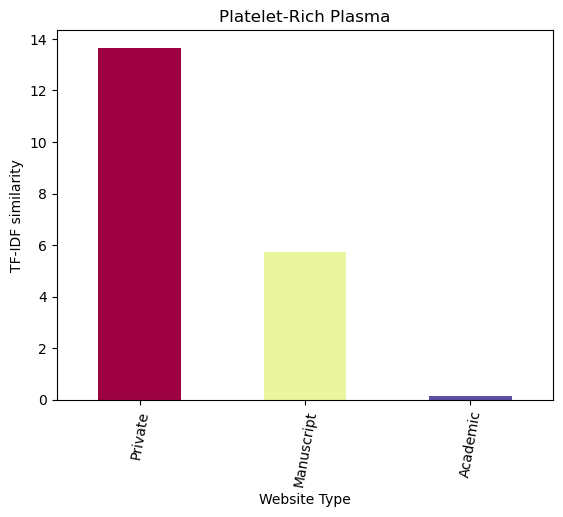

In [132]:
n = 10
top_n_sites = list(sorted_weights.keys())[:n]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
df.loc[top_n_sites].plot.bar(x = 'Name', y = 'Weight', \
                            #   yerr = 'Error',\
                              legend = None, \
                              color = plt.get_cmap('Spectral_r')(rescale(df.loc[top_n_sites].Weight.values)))
plt.xticks(rotation = 80)

# plt.title("Tennis Elbow")
# plt.title("Carpal Tunnel Syndrome")
plt.title("Platelet-Rich Plasma")
plt.xlabel('Website Type')
plt.ylabel('TF-IDF similarity')
plt.show()
# plt.gca().invert_yaxis()

# Compare lexical diversity

In [203]:
# # !pip install lexicalrichness
# from lexicalrichness import LexicalRichness
# from scipy import stats

In [204]:
# # find Measure of Textual Lexical Diversity (MTLD) (McCarthy & Jarvis 2010)
# mtld_w = [LexicalRichness(data.loc[f'W{i}'].text).mtld(threshold=0.72) for i in range(1, 51)]
# mtld_c = [LexicalRichness(data.loc[f'C{i}'].text).mtld(threshold=0.72) for i in range(1, 21)]

In [205]:
# plt.hist(mtld_c, bins=6);

In [206]:
# plt.hist(mtld_w, bins=6);

In [207]:
# # Mann-Whitney U test
# res = stats.mannwhitneyu(mtld_w, mtld_c)
# print("p value:", res[1])

# Plot for paper (GPT-3.5 vs -4)

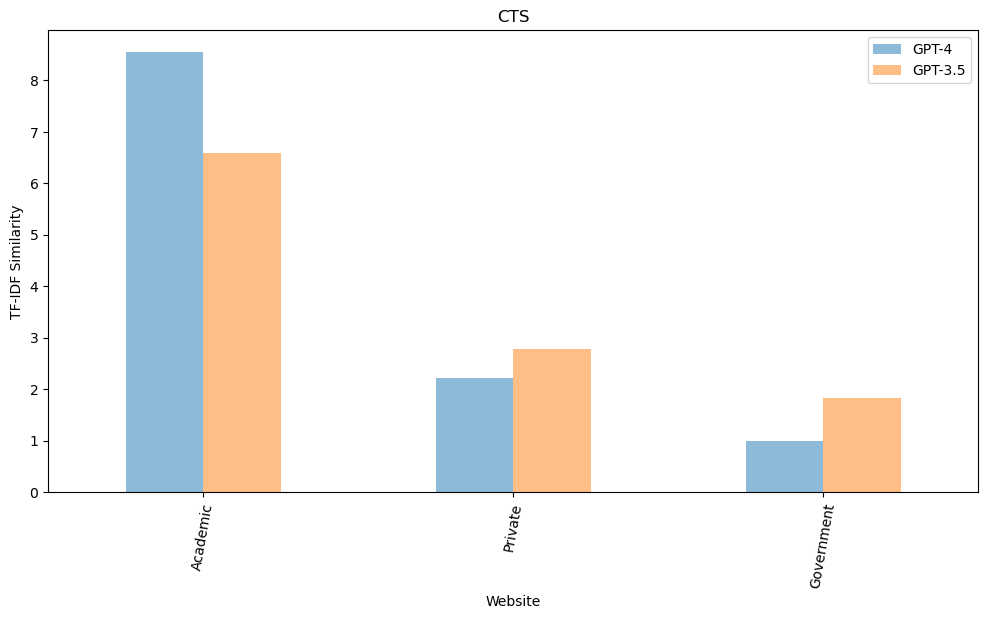

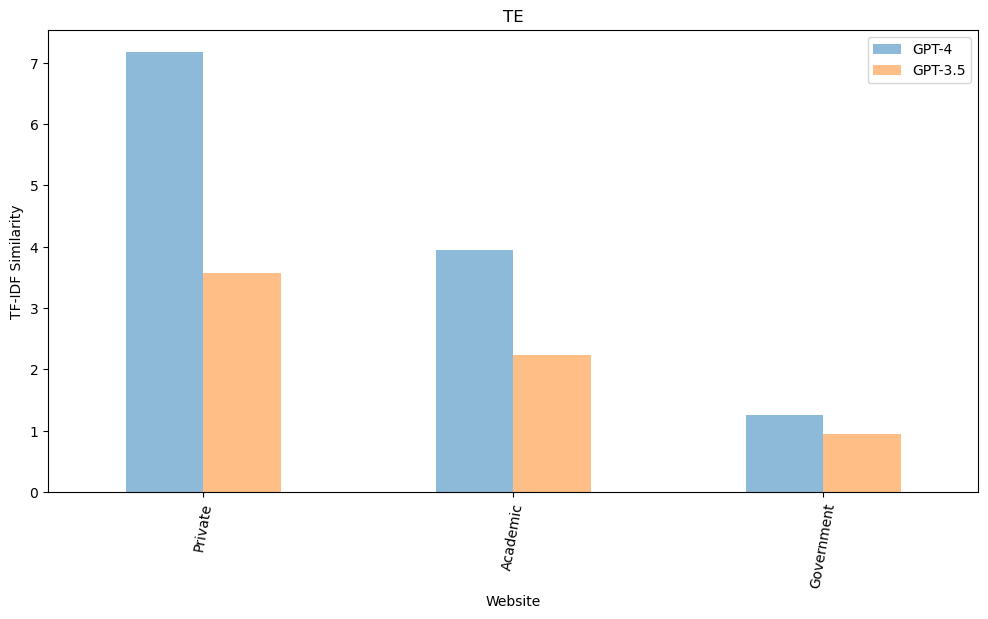

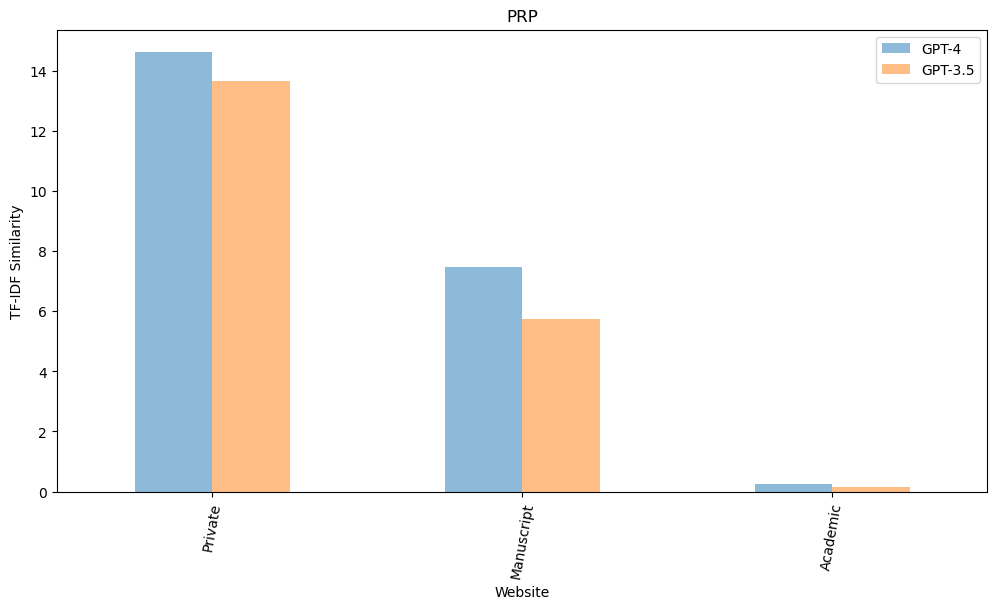

In [18]:
labels = ('CTS', 'TE', 'PRP')

dfs = [pd.read_csv(f'NA_results_{i}_type.csv') for i in labels]

for df, label in zip(dfs, labels):

    # Sort dataframe by GPT-4 weight in descending order
    df = df.sort_values('Weight4', ascending=False)

    # Set index to 'name' column
    #df = df.set_index('Name')
    df = df.set_index('Unnamed: 0')

    # Create a bar plot with 'score A' and 'score B' and their respective errors
    ax = df[['Weight4', 'Weight3.5']].plot(kind='bar', #yerr=df[['Error4', 'Error3.5']].values.T, 
                                           alpha=0.5, figsize=(12, 6))

    # Set labels
    ax.set_ylabel('TF-IDF Similarity')
    ax.set_xlabel('Website')

    # Rotation of tick labels
    plt.xticks(rotation = 80)

    # Set title
    ax.set_title(f'{label}')

    # Add legend
    ax.legend(['GPT-4', 'GPT-3.5'])

    # Show the plot
    plt.show()